# Data prep

In [74]:
import matplotlib.pyplot as plt
# Load pickled data
import pickle
import numpy as np
from functools import partial

# TODO: Fill this in based on where you saved the training and testing data

DATA_DIR = "./data/"

training_file = DATA_DIR + "traffic-signs-data/train.p"
validation_file = DATA_DIR + "traffic-signs-data/valid.p"
testing_file = DATA_DIR + "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, X_train_coords, X_train_sizes, y_train = np.asarray(train['features'], dtype=np.float32), train['coords'], train['sizes'], train['labels']
X_valid, X_valid_coords,X_valid_sizes, y_valid = np.asarray(valid['features'], dtype=np.float32), valid['coords'], valid['sizes'], valid['labels']
X_test, X_test_coords, X_test_sizes, y_test = np.asarray(test['features'], dtype=np.float32), test['coords'], test['sizes'], test['labels']

#################

### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

##################


### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
# Visualizations will be shown in the notebook.
#TODO(saajan): uncomment line below and plot and do more visualization
# %matplotlib inline
 
# plt.hist(y_train, alpha=0.5, label='training_labels', bins=43)
# plt.hist(y_valid, alpha=0.5, label='validation_labels', bins=43)
# plt.hist(y_test, alpha=0.5, label='test_labels', bins=43)
# plt.legend(loc='upper right')
# plt.show()

###################
import random

def show_sample_images(Xs, count):
    fig = plt.figure()
    for i in range(count):
        index = random.randint(0, len(Xs)-1)
        image = Xs[index].squeeze()
        ax1 = fig.add_subplot(1,count,i+1)
        ax1.imshow(image)
        #ax1.imshow(image, cmap="gray")
        
        #plt.imshow(image, cmap="gray")
        #plt.imshow(image)
           
# show_sample_images(X_train, 10)

### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.    

def saveAndRetrievePickle(transformFunc, featuresDict, mode, pickleFileName):
    if mode == 'saveAndRetrieve':
        X_train_features = np.array([transformFunc(X_train_image) for X_train_image in featuresDict['X_train']])
        X_valid_features = np.array([transformFunc(X_valid_image) for X_valid_image in featuresDict['X_valid']])
        X_test_features = np.array([transformFunc(X_test_image) for X_test_image in featuresDict['X_test']])
             
        new_features_dict = {'X_train': X_train_features, 'y_train': y_train, 'X_valid': X_valid_features,\
                            'y_valid': y_valid, 'X_test': X_test_features, 'y_test': y_test}
    
        with open(DATA_DIR + pickleFileName + '.pickle', 'wb') as handle:
            pickle.dump(new_features_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
      
    if mode == 'saveAndRetrieve' or mode == 'retrieve':
        with open(DATA_DIR + pickleFileName + '.pickle', 'rb') as handle:
            new_features_dict = pickle.load(handle)
    
    return new_features_dict
            
   
# Original_data
def noop_image(image):
    return np.asarray(image, dtype=np.float32) 

print("# Original_data")
original_data = {'X_train': X_train, 'y_train': y_train, 'X_valid': X_valid, 'y_valid': y_valid, 'X_test': X_test, 'y_test': y_test}
# original_data = saveAndRetrievePickle(noop_image, original_data, 'saveAndRetrieve', 'original_data')
original_data = saveAndRetrievePickle(noop_image, original_data, 'retrieve', 'original_data') 


# Create cropped data
#TODO(saajan): Reconsider zeroing out irrelevant area over resizing cropped image
def extract_bounds_and_rescale(image, coord, size):
    transformed_x = 32
    transformed_y = 32
    original_x = size[0]
    original_y = size[1]
      
    x_multiplier = float(transformed_x)/float(original_x)
    y_multiplier = float(transformed_y)/float(original_y)
      
    transformed_coord = (coord[0]* x_multiplier, coord[1] * y_multiplier, coord[2] * x_multiplier, coord[3] * y_multiplier)
    transformed_coord = [int(np.rint(val)) for val in transformed_coord]
      
    ret_image = image.copy()
    shape = image.shape
     
    ret_image[0:transformed_coord[0],:] = (0,0,0)
    ret_image[:,0:transformed_coord[1]] = (0,0,0)
    ret_image[transformed_coord[2]:shape[1],:] = (0,0,0)
    ret_image[:,transformed_coord[3]:shape[0]] = (0,0,0)
    #show_sample_images([ret_image], 1)
    return np.asarray(ret_image, dtype=np.float32)


# # extract_bounds_and_rescale Xs
# X_train = np.array([extract_bounds_and_rescale(image, coord, size) for (image, coord, size) in zip(X_train, X_train_coords, X_train_sizes)])
# X_valid = np.array([extract_bounds_and_rescale(image, coord, size) for (image, coord, size) in zip(X_valid, X_valid_coords,X_valid_sizes)])
# X_test = np.array([extract_bounds_and_rescale(image, coord, size) for (image, coord, size) in zip(X_test, X_test_coords, X_test_sizes)])
  
print("# Cropped_data")
# cropped_data = {'X_train': X_train, 'y_train': y_train, 'X_valid': X_valid, 'y_valid': y_valid, 'X_test': X_test, 'y_test': y_test}
# with open(DATA_DIR + 'cropped_data.pickle', 'wb') as cropped_data_handle:
#     pickle.dump(cropped_data, cropped_data_handle, protocol=pickle.HIGHEST_PROTOCOL)
  
with open(DATA_DIR + 'cropped_data.pickle', 'rb') as cropped_data_handle:
    cropped_data = pickle.load(cropped_data_handle)
     
# show_sample_images(cropped_data['X_train'], 10)


# normalize Xs
def normalize(image, mean_pixel):
    result = (np.asarray(image, dtype=np.float32) - mean_pixel) / mean_pixel
    #normalizer_func = np.vectorize(lambda val: (float(val)-float(mean_pixel))/float(mean_pixel))
    return np.asarray(result, dtype=np.float32)

print("# Original_normalized_data")
# original_normalized_data = saveAndRetrievePickle(partial(normalize, mean_pixel=np.mean([np.mean(image) for image in original_data['X_train']])), original_data, 'saveAndRetrieve', 'original_normalized_data')
original_normalized_data = saveAndRetrievePickle(partial(normalize, mean_pixel=np.mean([np.mean(image) for image in original_data['X_train']])), original_data, 'retrieve', 'original_normalized_data')

print("# Cropped_normalized_data")
# cropped_normalized_data = saveAndRetrievePickle(partial(normalize, mean_pixel=np.mean([np.mean(image) for image in cropped_data['X_train']])), cropped_data, 'saveAndRetrieve', 'cropped_normalized_data')
cropped_normalized_data = saveAndRetrievePickle(partial(normalize, mean_pixel=np.mean([np.mean(image) for image in cropped_data['X_train']])), cropped_data, 'retrieve', 'cropped_normalized_data')
   
# # Experiments
# vals = []
# for image in cropped_normalized_data['X_train']:
#     vals.append((np.mean(image)))
# print(np.mean(vals))    


import cv2
# convert_to_grayscale Xs
def convert_to_grayscale(image):
    return np.asarray(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), dtype=np.float32).reshape((32, 32, 1))
    
print("# Cropped_grayscale_data")
# cropped_grayscale_data = saveAndRetrievePickle(convert_to_grayscale, cropped_data, 'saveAndRetrieve', 'cropped_grayscale_data')
cropped_grayscale_data = saveAndRetrievePickle(convert_to_grayscale, cropped_data, 'retrieve', 'cropped_grayscale_data') 

print("# Cropped_grayscaled_normalized_data")
# cropped_grayscaled_normalized_data = saveAndRetrievePickle(partial(normalize, mean_pixel=np.mean([np.mean(image) for image in cropped_grayscale_data['X_train']])), cropped_grayscale_data, 'saveAndRetrieve', 'cropped_grayscaled_normalized_data')
cropped_grayscaled_normalized_data = saveAndRetrievePickle(partial(normalize, mean_pixel=np.mean([np.mean(image) for image in cropped_grayscale_data['X_train']])), cropped_grayscale_data, 'retrieve', 'cropped_grayscaled_normalized_data') 

#Naming
original_data['name'] = 'original_data'
original_normalized_data['name'] = 'original_normalized_data'
cropped_data['name'] = 'cropped_data'
cropped_grayscale_data['name'] = 'cropped_grayscale_data'
cropped_normalized_data['name'] = 'cropped_normalized_data'
cropped_grayscaled_normalized_data['name'] = 'cropped_grayscaled_normalized_data'
#all_data = [original_data, original_normalized_data, cropped_data, cropped_normalized_data, cropped_grayscale_data, cropped_grayscaled_normalized_data] 
#all_data = [original_normalized_data, cropped_grayscale_data] 
all_data = [original_normalized_data] 

print('Done with data prep!')

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
# Original_data
# Original_normalized_data
82.6776
# Cropped_normalized_data
48.38
1.14006e-08
# Cropped_grayscale_data
# Cropped_grayscaled_normalized_data
47.6308
Done with data prep!


Stored 'current_data_dict' (dict)
Stored 'current_data_dict_name' (str)

Image Shape: (32, 32, 3)

Training Set:   34799 samples
Validation Set: 4410 samples
Test Set:       12630 samples
(32, 32, 3)


Epoch:   0%|          | 0/1 [00:00<?, ?epochs/s]

Model exists. Restoring from: ./data/original_normalized_data_0...
INFO:tensorflow:Restoring parameters from ./data/original_normalized_data_0


Epoch: 100%|██████████| 1/1 [00:11<00:00, 11.17s/epochs]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1, right=1
  'left=%s, right=%s') % (left, right))


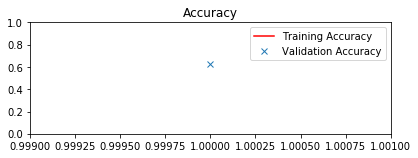

Training accuracies: 
[0.73137159109828132]
Validation accuracies: 
[0.62743764153413495]
INFO:tensorflow:Restoring parameters from ./data/original_normalized_data_0
Test Accuracy = 0.619
All done...!


In [104]:
#%%capture output
for index, data_dict in enumerate(all_data):
    current_data_dict = data_dict
    current_data_dict_name = data_dict['name']
    %store current_data_dict
    %store current_data_dict_name
    %run LeNet_eval.ipynb 'current_data_dict'
print("All done...!")

In [83]:
#output.show()